In [81]:
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import joblib
from catboost import CatBoostRegressor, Pool, EFstrType
import statistics
from sklearn.model_selection import KFold
import time
from utils import calculate_metric
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
import shap
import matplotlib
import seaborn as sns

In [2]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)

In [3]:
INPUT_FILE = "../data/data_removing_na.xlsx"
OUTPUT_PATH = '../output/catboost'
BATCH_SIZE = 32

OUTPUT_FILE = OUTPUT_PATH + '/catboost.pkl'
TRAINING_OUTPUT_FILE = '../output/train_predictions.xlsx'
TEST_OUTPUT_FILE = '../output/test_predictions.xlsx'
SHEET_NAME = "catboost"

DEVICE = 'GPU' if torch.cuda.is_available() else 'CPU'
DEVICES = [0, 1, 2, 3]

In [4]:
# create path
output_dir = Path(OUTPUT_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
DEVICE

'CPU'

In [6]:
df = pd.read_excel(INPUT_FILE)

In [7]:
df.head()

,rr1_30,currency,seniorioty_adj,coupon rate,domicile_country,exchange_country,Industry_sector,Industry_group,Industry_subgroup,event_type,...,PD_55_pd,PD_56_pd,PD_57_pd,PD_58_pd,PD_59_pd,PD_60_pd,DTD,NI_Over_TA,Size,defaulted_in_last_6_months
0,0.259908,USD,Senior Subordinated Unsecured,9.000,United States,United States,Consumer Discretionary,Retail & Whsle - Discretionary,E-Commerce Discretionary,Bankruptcy Filing,...,0.396731,0.397453,0.398148,0.398819,0.399467,0.400092,-0.732815,-0.007137,-0.852484,False
1,0.032729,USD,Senior Subordinated Unsecured,5.750,United States,United States,Health Care,Health Care,Health Care Facilities & Svcs,Default Corp Action,...,0.957454,0.957467,0.957480,0.957492,0.957503,0.957514,-1.666262,-0.000286,-1.186347,False
2,0.972400,USD,Unsecured,5.675,South Korea,South Korea,Consumer Discretionary,Retail & Whsle - Discretionary,Wholesale - Discretionary,Default Corp Action,...,0.568169,0.568693,0.569197,0.569682,0.570150,0.570600,-1.853366,0.000191,1.053677,False
3,1.047416,CHF,Unsecured,0.125,South Korea,South Korea,Consumer Discretionary,Retail & Whsle - Discretionary,Wholesale - Discretionary,Default Corp Action,...,0.568169,0.568693,0.569197,0.569682,0.570150,0.570600,-1.853366,0.000191,1.053677,False
4,0.848872,JPY,Unsecured,1.750,Japan,Japan,Industrials,Industrial Products,Electrical Equipment,Bankruptcy Filing,...,0.130285,0.130688,0.131081,0.131465,0.131840,0.132206,-0.768857,-0.028058,-1.946507,False


In [8]:
df.shape

(1725, 165)

In [9]:
feature_list = df.columns
feature_list = feature_list.drop('rr1_30')

In [10]:
feature_list

Index(['currency', 'seniorioty_adj', 'coupon rate', 'domicile_country',
       'exchange_country', 'Industry_sector', 'Industry_group',
       'Industry_subgroup', 'event_type', 'event_type_subcategory_sum',
       ...
       'PD_55_pd', 'PD_56_pd', 'PD_57_pd', 'PD_58_pd', 'PD_59_pd', 'PD_60_pd',
       'DTD', 'NI_Over_TA', 'Size', 'defaulted_in_last_6_months'],
      dtype='object', length=164)

In [11]:
category_features = list(df.select_dtypes(include=['object', 'bool']).columns)
non_category_features = [i for i in feature_list if i not in category_features]

In [12]:
print(len(non_category_features))
print(len(category_features))

153
11


In [13]:
category_features

['currency',
 'seniorioty_adj',
 'domicile_country',
 'exchange_country',
 'Industry_sector',
 'Industry_group',
 'Industry_subgroup',
 'event_type',
 'event_type_subcategory_sum',
 'defaulted_in_last_5_years',
 'defaulted_in_last_6_months']

In [14]:
# split data into training and test set
test_size = 0.25
train, test = train_test_split(df, test_size=test_size, random_state=42)

In [15]:
target_col = 'rr1_30'
train_features = train.drop(columns=target_col)
train_labels = train[target_col]
test_features = test.drop(columns=target_col)
test_labels = test[target_col]

In [16]:
train_features.shape

(1293, 164)

TUNING PARAMETERS

In [17]:
# empty cache first
torch.cuda.empty_cache()

In [49]:
def objective(trial):
    
    # Define the hyperparameter search space
    param = {
        'task_type': DEVICE,
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'verbose': 0
    }
    
    # Add GPU-specific parameters if using GPU
    if DEVICE == 'GPU':
        param['devices'] = DEVICES
        # # GPU-specific parameters
        # param['gpu_ram_part'] = trial.suggest_float('gpu_ram_part', 0.3, 0.95)
        # param['pinned_memory_size'] = trial.suggest_int('pinned_memory_size', 1073741824, 3221225472)  # 1-3 GB
    else:
        # CPU-specific parameters
        param['thread_count'] = 4
    
    # training with 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for index, (train_idx, val_idx) in enumerate(kf.split(train)):
        # Create training and validation datasets for the current fold
        X_train, X_valid = train_features.iloc[train_idx], train_features.iloc[val_idx]
        y_train, y_valid = train_labels.iloc[train_idx], train_labels.iloc[val_idx]
        
        # Create CatBoost Pools
        train_pool = Pool(X_train, y_train, cat_features=category_features)
        valid_pool = Pool(X_valid, y_valid, cat_features=category_features)
        
        # Initialize model with trial parameters
        model = CatBoostRegressor(**param)
        
        # Train model
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True, early_stopping_rounds=20, verbose=False)
        
        # Predict and evaluate
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_scores.append(rmse)

        trial.report(rmse, index)

    # Return the average validation loss across all folds
    return np.mean(rmse_scores)


In [50]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction="minimize") #, pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, timeout=3600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-04-01 10:44:14,708] A new study created in memory with name: no-name-694079da-0992-427e-82b7-9abbd64318d9
[I 2025-04-01 10:44:57,047] Trial 0 finished with value: 0.24367153365277533 and parameters: {'iterations': 960, 'learning_rate': 0.005995716627789941, 'depth': 4, 'l2_leaf_reg': 0.03681907440026173, 'random_strength': 0.0018261223867335418, 'bagging_temperature': 6.726203010858286, 'border_count': 214, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.24367153365277533.
[I 2025-04-01 10:45:33,455] Trial 1 finished with value: 0.2484476075535463 and parameters: {'iterations': 410, 'learning_rate': 0.004087635518078224, 'depth': 6, 'l2_leaf_reg': 0.0055943819948289794, 'random_strength': 0.014267237392397618, 'bagging_temperature': 5.222666035263908, 'border_count': 82, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.24367153365277533.
[I 2025-04-01 10:46:55,999] Trial 2 finished with value: 0.2323296526419985 and parameters: {'iterations': 761, 'learning

Study statistics: 
  Number of finished trials:  76
  Number of pruned trials:  0
  Number of complete trials:  76
Best trial:
  Value:  0.22900420939705374
  Params: 
    iterations: 861
    learning_rate: 0.07109772423259975
    depth: 8
    l2_leaf_reg: 0.013151449307810441
    random_strength: 0.3582709029479316
    bagging_temperature: 8.516559613305308
    border_count: 101
    grow_policy: Lossguide


In [51]:
trial.params

{'iterations': 861,
 'learning_rate': 0.07109772423259975,
 'depth': 8,
 'l2_leaf_reg': 0.013151449307810441,
 'random_strength': 0.3582709029479316,
 'bagging_temperature': 8.516559613305308,
 'border_count': 101,
 'grow_policy': 'Lossguide'}

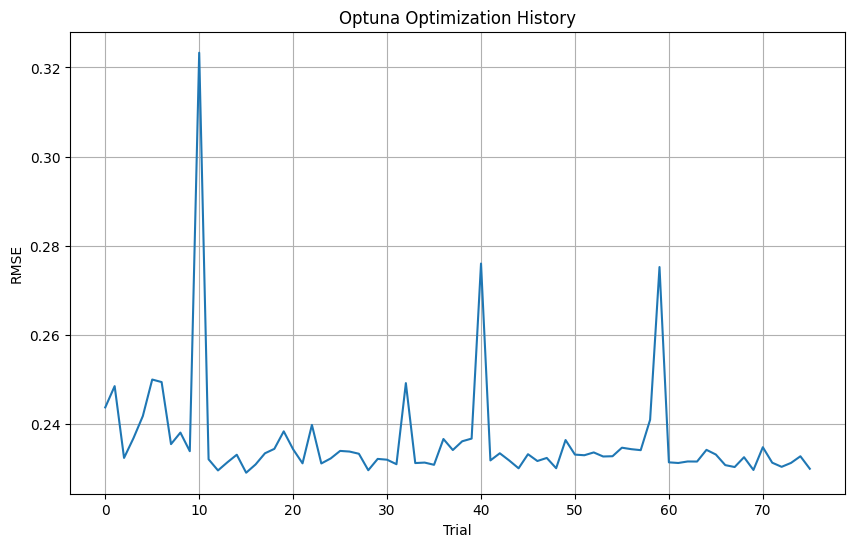

In [52]:
 # Visualize optimization history
plt.figure(figsize=(10, 6))
optimization_history = np.array(study.trials_dataframe()['value'])
plt.plot(optimization_history)
plt.xlabel('Trial')
plt.ylabel('RMSE')
plt.title(f'Optuna Optimization History')
plt.grid(True)
plt.show()

RUNNING THE MODEL

In [53]:
# empty cache first
torch.cuda.empty_cache()

In [18]:
best_param = {'iterations': 861,
 'learning_rate': 0.07109772423259975,
 'depth': 8,
 'l2_leaf_reg': 0.013151449307810441,
 'random_strength': 0.3582709029479316,
 'bagging_temperature': 8.516559613305308,
 'border_count': 101,
 'grow_policy': 'Lossguide'}

In [19]:
# best_param = trial.params
best_param['verbose'] = 100  # Set verbose for detailed logs

# Create CatBoost Pools
train_pool = Pool(train_features, train_labels, cat_features=category_features)
valid_pool = Pool(test_features, test_labels, cat_features=category_features)

start_time = time.time()

# Initialize model with trial parameters
model = CatBoostRegressor(**best_param)

# Train model
model.fit(train_pool, verbose=True)

# print out training time
elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

0:	learn: 0.3189973	total: 72ms	remaining: 1m 1s
1:	learn: 0.3106048	total: 85.3ms	remaining: 36.6s
2:	learn: 0.3019335	total: 101ms	remaining: 28.8s
3:	learn: 0.2943482	total: 113ms	remaining: 24.3s
4:	learn: 0.2869960	total: 126ms	remaining: 21.6s
5:	learn: 0.2798197	total: 141ms	remaining: 20.1s
6:	learn: 0.2732156	total: 154ms	remaining: 18.8s
7:	learn: 0.2687710	total: 168ms	remaining: 17.9s
8:	learn: 0.2633895	total: 182ms	remaining: 17.2s
9:	learn: 0.2579657	total: 196ms	remaining: 16.7s
10:	learn: 0.2524886	total: 210ms	remaining: 16.2s
11:	learn: 0.2476175	total: 222ms	remaining: 15.7s
12:	learn: 0.2427037	total: 236ms	remaining: 15.4s
13:	learn: 0.2384724	total: 250ms	remaining: 15.1s
14:	learn: 0.2350419	total: 265ms	remaining: 14.9s
15:	learn: 0.2312901	total: 279ms	remaining: 14.7s
16:	learn: 0.2269195	total: 298ms	remaining: 14.8s
17:	learn: 0.2235536	total: 314ms	remaining: 14.7s
18:	learn: 0.2208995	total: 332ms	remaining: 14.7s
19:	learn: 0.2178292	total: 351ms	remaini

In [42]:
# Predict and evaluate
train_predictions = model.predict(train_features)

# save metrics
mae, mape, rmse, rsqr = calculate_metric(train_predictions, train_labels.to_numpy())
print(f"Training average mean absolute error: {mae}")
print(f"Training average mean absolute percentage error: {mape}")
print(f"Training average root mean squared error: {rmse}")
print(f"Training average R2: {rsqr}")

Training average mean absolute error: 0.030414505036261343
Training average mean absolute percentage error: 227.4466923460614
Training average root mean squared error: 0.060533003736972894
Training average R2: 0.9662242301524595


In [21]:
# Predict and evaluate
predictions = model.predict(test_features)

# save metrics
mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels.to_numpy())
print(f"Test average mean absolute error: {mae}")
print(f"Test average mean absolute percentage error: {mape}")
print(f"Test average root mean squared error: {rmse}")
print(f"Test average R2: {rsqr}")

Test average mean absolute error: 0.1331949993669022
Test average mean absolute percentage error: 340.03935484900956
Test average root mean squared error: 0.2230146568236924
Test average R2: 0.5657953253456582


In [62]:
# save train predictions
train_predictions_df = pd.DataFrame({"predictions": train_predictions})
with pd.ExcelWriter(TRAINING_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    train_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    
# save test predictions
test_predictions_df = pd.DataFrame({"predictions": predictions})
with pd.ExcelWriter(TEST_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    test_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)

# Save the best model
joblib.dump(model, OUTPUT_FILE)

['../output/catboost/catboost.pkl']

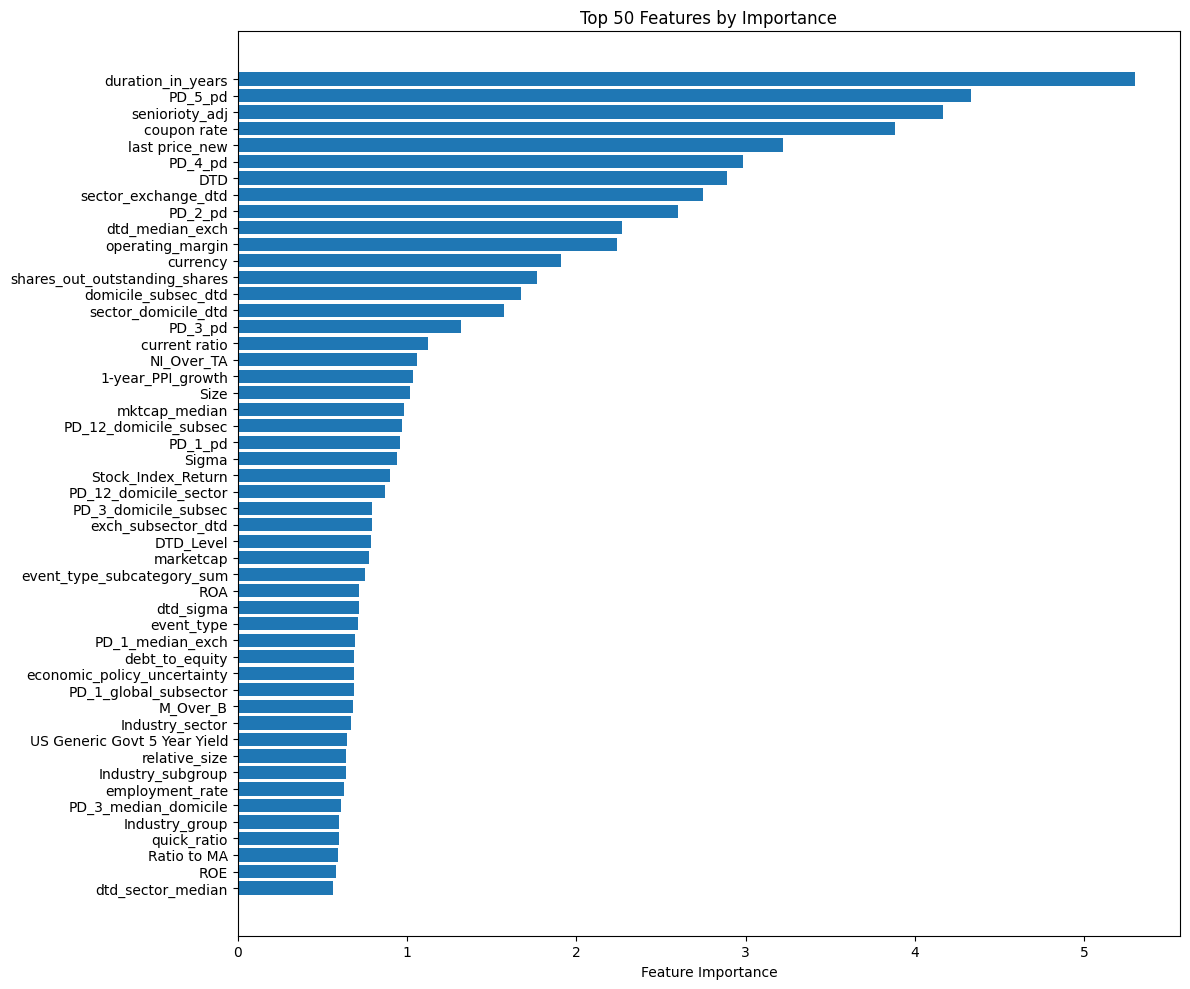

In [63]:
# Plot feature importance
feature_importance = model.get_feature_importance()
feature_names = train_features.columns

# Sort features by importance in descending order
sorted_idx = np.argsort(feature_importance)[::-1]

top_k = min(50, len(sorted_idx))
top_idx = sorted_idx[:top_k]

plt.figure(figsize=(12, 10))
plt.barh(range(len(top_idx)), feature_importance[top_idx])
plt.yticks(range(len(top_idx)), feature_names[top_idx])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_k} Features by Importance')
plt.gca().invert_yaxis()  # Display highest importance at the top
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/Feature_importances.png")
plt.show()

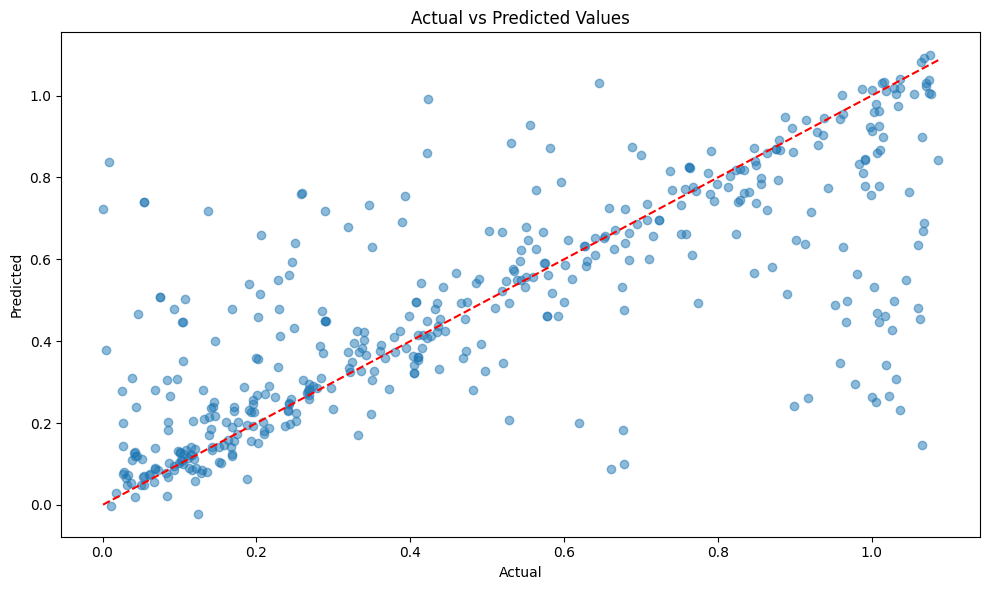

In [ ]:
# Compare predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

SHAP

Training SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
explanation = explainer(train_features)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
diff = np.abs(shap_values.sum(axis=1) + explanation.base_values - train_predictions)
diff.max()

0.6821039259254216

=> Big difference may be due to the interaction values

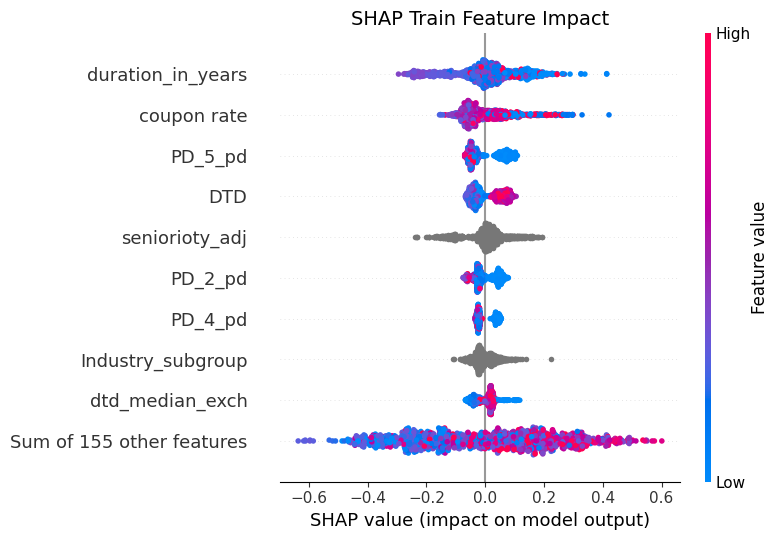

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  # Adjust size as needed
# Create the beeswarm plot
shap.plots.beeswarm(explanation, show=False)  # Set show=False to prevent automatic display
# Add title if desired
plt.title("SHAP Train Feature Impact", fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_train_feature_beeswarm.png')
plt.show()

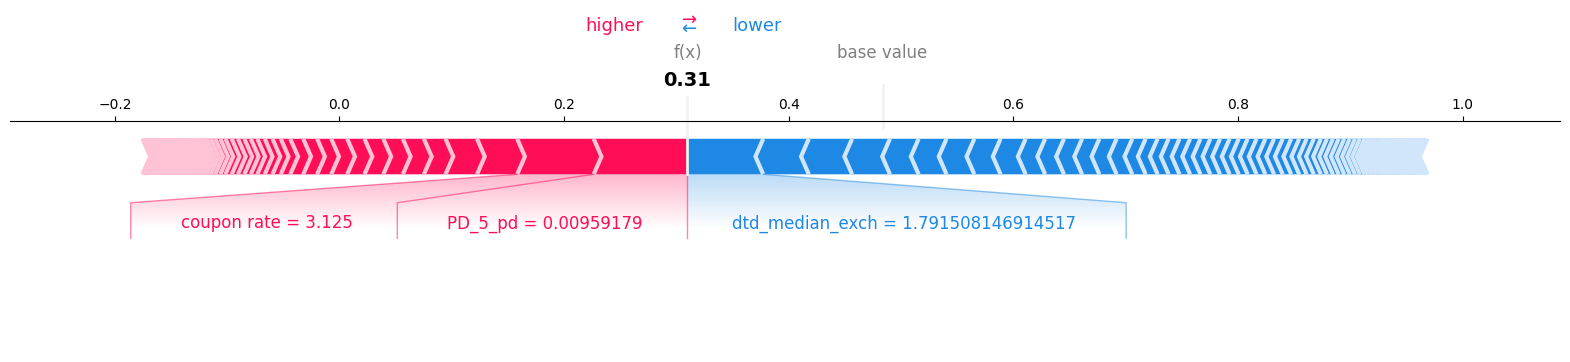

In [93]:

# visualize the first prediction's explanation
shap.plots.force(explanation[0, ...], matplotlib=matplotlib)

In [78]:
shap_interaction_values = explainer.shap_interaction_values(train_features)
print(f"shape: ", shap_interaction_values.shape)

shape:  (1293, 164, 164)


In [80]:
# Aggregate interaction effects across samples
interaction_matrix = np.abs(shap_interaction_values).sum(0)

# Create a DataFrame for easy manipulation
interaction_df = pd.DataFrame(
    interaction_matrix,
    index=train_features.columns,
    columns=train_features.columns
)

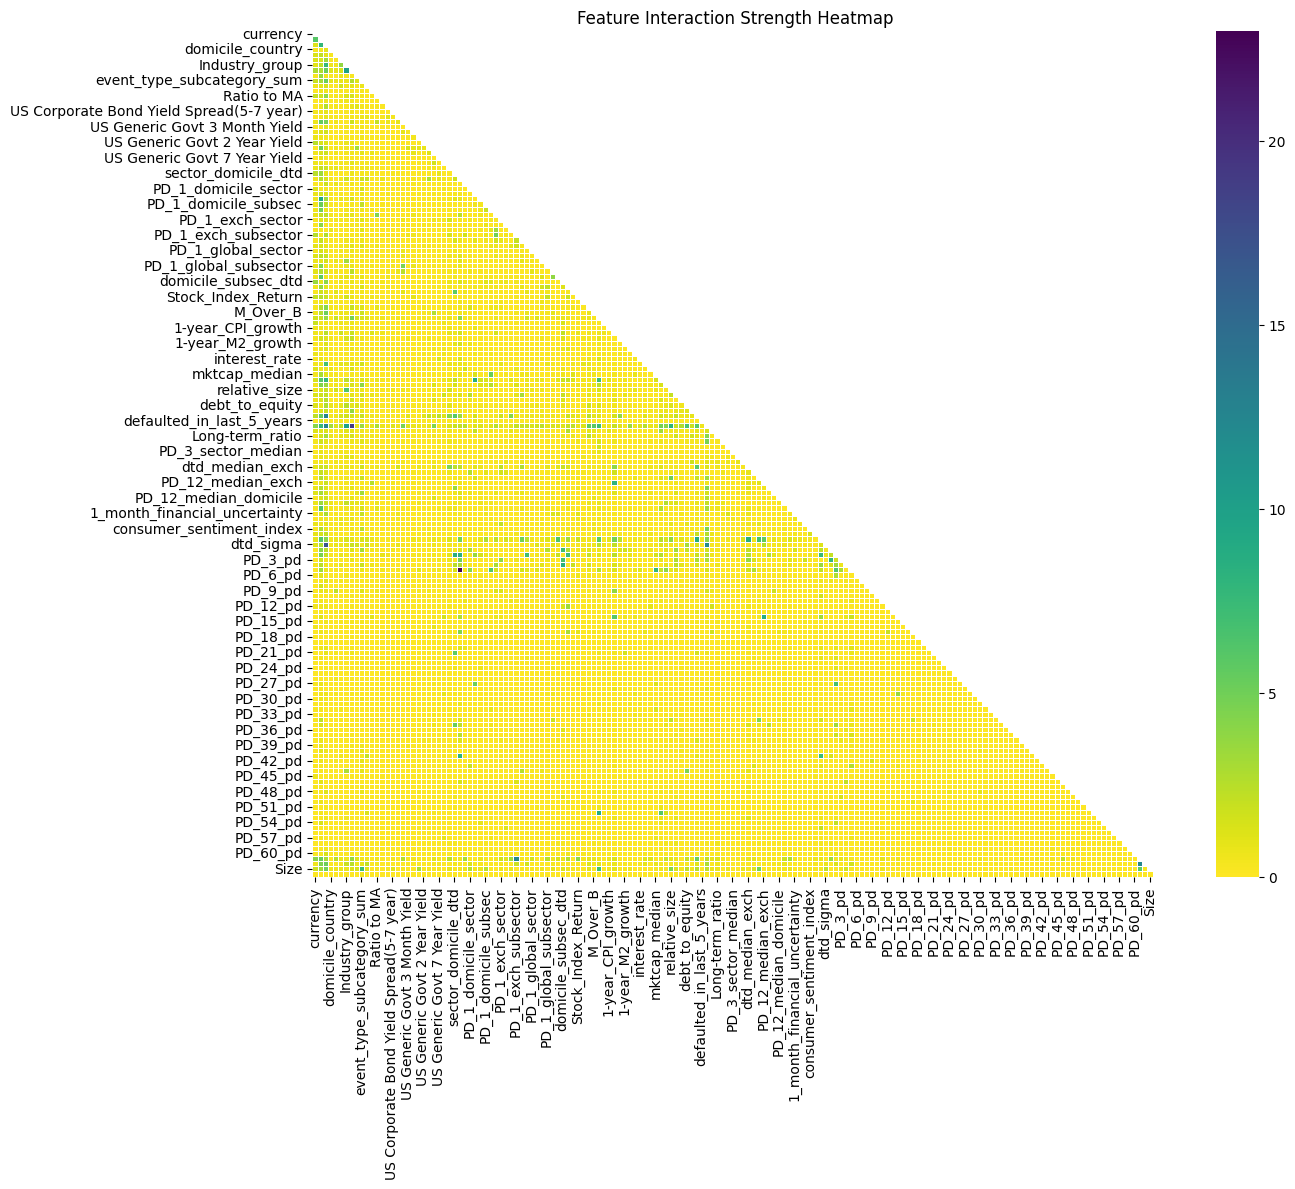

In [82]:
# Create a symmetric interaction matrix for the heatmap
symmetric_interaction = interaction_df.copy()
for i in range(len(train_features.columns)):
    for j in range(i+1, len(train_features.columns)):
        # Sum both directions of the interaction
        total = symmetric_interaction.iloc[i, j] + symmetric_interaction.iloc[j, i]
        symmetric_interaction.iloc[i, j] = total
        symmetric_interaction.iloc[j, i] = total
    # Set diagonal to 0 to focus on interactions
    symmetric_interaction.iloc[i, i] = 0

# Plot the heatmap
plt.figure(figsize=(15, 12))
mask = np.zeros_like(symmetric_interaction, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask upper triangle
heatmap = sns.heatmap(
    symmetric_interaction,
    mask=mask,
    cmap='viridis_r',
    linewidths=0.5,
    annot=False,
    square=True
)
plt.title('Feature Interaction Strength Heatmap')
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_interaction_heatmap.png')
plt.show()

SHAP for testing set

In [84]:
explainer = shap.TreeExplainer(model)
explanation = explainer(test_features)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
diff = np.abs(shap_values.sum(axis=1) + explanation.base_values - predictions)
diff.max()

0.7193818274505746

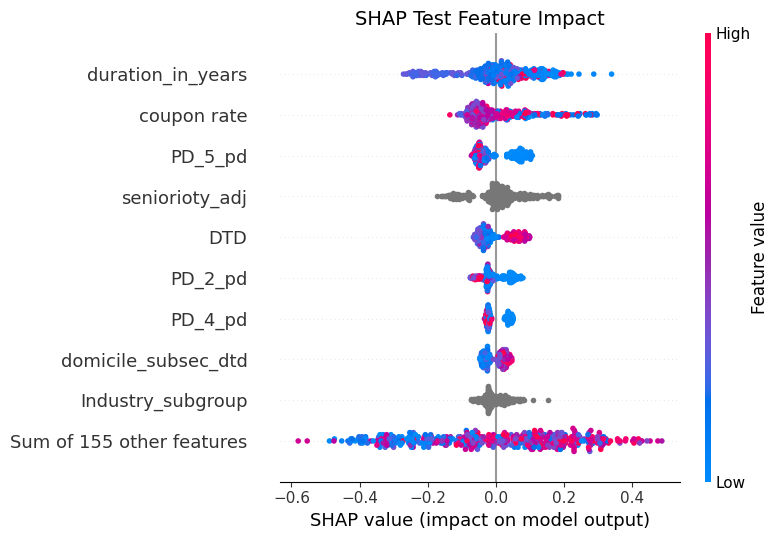

In [92]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  # Adjust size as needed
# Create the beeswarm plot
shap.plots.beeswarm(explanation, show=False)  # Set show=False to prevent automatic display
# Add title if desired
plt.title("SHAP Test Feature Impact", fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_test_feature_beeswarm.png')
plt.show()

In [87]:
shap_interaction_values = explainer.shap_interaction_values(test_features)
print(f"shape: ", shap_interaction_values.shape)

shape:  (432, 164, 164)


In [88]:
# Aggregate interaction effects across samples
interaction_matrix = np.abs(shap_interaction_values).sum(0)

# Create a DataFrame for easy manipulation
interaction_df = pd.DataFrame(
    interaction_matrix,
    index=train_features.columns,
    columns=train_features.columns
)

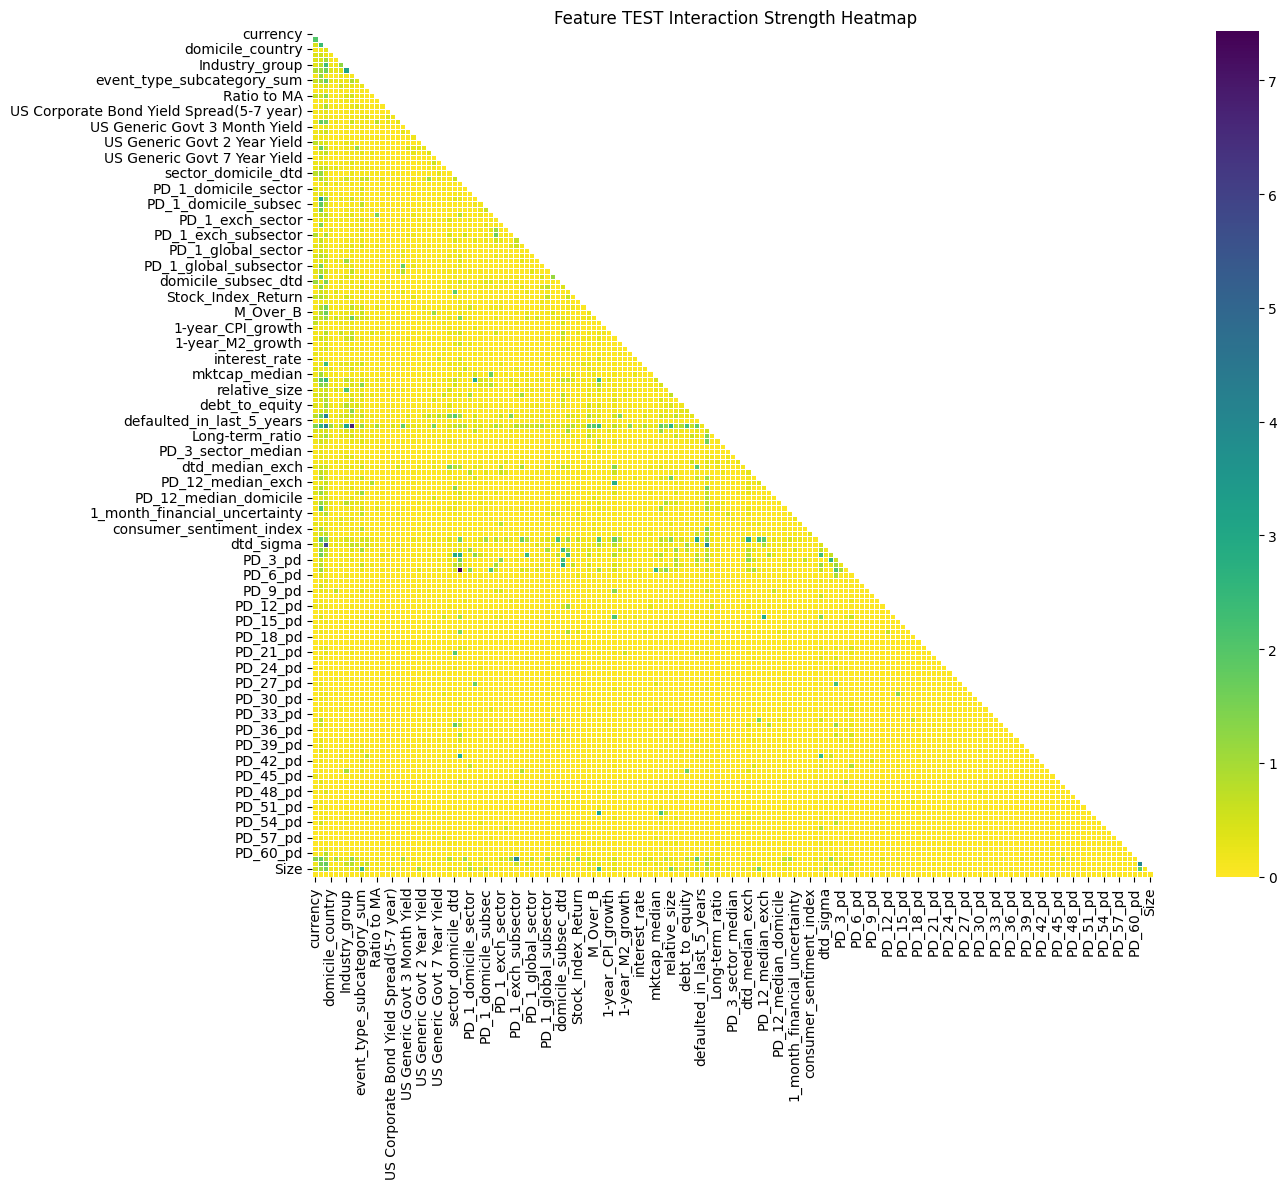

In [89]:
# Create a symmetric interaction matrix for the heatmap
symmetric_interaction = interaction_df.copy()
for i in range(len(train_features.columns)):
    for j in range(i+1, len(train_features.columns)):
        # Sum both directions of the interaction
        total = symmetric_interaction.iloc[i, j] + symmetric_interaction.iloc[j, i]
        symmetric_interaction.iloc[i, j] = total
        symmetric_interaction.iloc[j, i] = total
    # Set diagonal to 0 to focus on interactions
    symmetric_interaction.iloc[i, i] = 0

# Plot the heatmap
plt.figure(figsize=(15, 12))
mask = np.zeros_like(symmetric_interaction, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask upper triangle
heatmap = sns.heatmap(
    symmetric_interaction,
    mask=mask,
    cmap='viridis_r',
    linewidths=0.5,
    annot=False,
    square=True
)
plt.title('Feature TEST Interaction Strength Heatmap')
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_test_interaction_heatmap.png')
plt.show()

5 fold CV

In [64]:
# Define cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
EPOCHS = 100
val_mae = []
val_mape = []
val_rmse = []
val_rsqr = []


features = df.drop(columns=target_col)
labels = df[target_col]

for index, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Create training and validation datasets for the current fold
        X_train, X_valid = features.iloc[train_idx], features.iloc[val_idx]
        y_train, y_valid = labels.iloc[train_idx], labels.iloc[val_idx]
        
        # Create CatBoost Pools
        train_pool = Pool(X_train, y_train, cat_features=category_features)
        
        # Initialize model with trial parameters
        model = CatBoostRegressor(**best_param)
        
        # Train model
        model.fit(train_pool, verbose=True)
        
        # Predict and evaluate
        preds = model.predict(X_valid)

        # Validation of the model.
        mae, mape, rmse, rsqr = calculate_metric(preds, y_valid.to_numpy())
        val_mae.append(mae)
        val_mape.append(mape)
        val_rmse.append(rmse)
        val_rsqr.append(rsqr)

0:	learn: 0.3198324	total: 14.6ms	remaining: 12.6s
1:	learn: 0.3113022	total: 28.6ms	remaining: 12.3s
2:	learn: 0.3031195	total: 41.9ms	remaining: 12s
3:	learn: 0.2962419	total: 54.9ms	remaining: 11.8s
4:	learn: 0.2888831	total: 70.8ms	remaining: 12.1s
5:	learn: 0.2819750	total: 85.1ms	remaining: 12.1s
6:	learn: 0.2756634	total: 100ms	remaining: 12.2s
7:	learn: 0.2687931	total: 115ms	remaining: 12.2s
8:	learn: 0.2631194	total: 131ms	remaining: 12.4s
9:	learn: 0.2578837	total: 145ms	remaining: 12.4s
10:	learn: 0.2531001	total: 159ms	remaining: 12.3s
11:	learn: 0.2488867	total: 174ms	remaining: 12.3s
12:	learn: 0.2436880	total: 189ms	remaining: 12.3s
13:	learn: 0.2390999	total: 202ms	remaining: 12.2s
14:	learn: 0.2351785	total: 217ms	remaining: 12.3s
15:	learn: 0.2317882	total: 233ms	remaining: 12.3s
16:	learn: 0.2278834	total: 248ms	remaining: 12.3s
17:	learn: 0.2246313	total: 262ms	remaining: 12.3s
18:	learn: 0.2213671	total: 278ms	remaining: 12.3s
19:	learn: 0.2190454	total: 296ms	rem

In [65]:
val_rmse

[0.2210661447839342,
 0.23894280476195812,
 0.21326508198512842,
 0.21656781076221246,
 0.22538716195823813]

In [67]:
print(f"Test average mean absolute error: {statistics.mean(val_mae)}")
print(f"Test average mean absolute percentage error: {statistics.mean(val_mape)}")
print(f"Test average root mean squared error: {statistics.mean(val_rmse)}")
print(f"Test average R2: {statistics.mean(val_rsqr)}")

Test average mean absolute error: 0.1378825218620453
Test average mean absolute percentage error: 5332.742692897226
Test average root mean squared error: 0.22304580085029427
Test average R2: 0.5445723486293756
